# Import Data

In [1]:
from helper import *

In [2]:
# root dir
root = 'data/'

# load in features and labels
logs = pd.read_csv(root + 'train_logs.csv')
scores = pd.read_csv(root + 'train_scores.csv')

# map scores to logs using id
logs = logs.merge(scores, on='id')

# check shape and nulls
show_shape_and_nulls(logs)

Shape: (8405898, 12)
Null values:


,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,0,0,0,0,0,0,0,0,0,0,0,0


- No null values.
- __logs__ is a massive dataset containing over 8 million rows, each being an independent keystroke/cursor action used in producing an essay.

In [3]:
# look at unique vals
show_unique_vals_and_dtypes(logs)

"id" (object) has 2471 unique values

"event_id" (int64) has 12876 unique values

"down_time" (int64) has 1836078 unique values

"up_time" (int64) has 1835993 unique values

"action_time" (int64) has 3509 unique values

"activity" (object) has 50 unique values

"down_event" (object) has 131 unique values

"up_event" (object) has 130 unique values

"text_change" (object) has 4111 unique values

"cursor_position" (int64) has 7803 unique values

"word_count" (int64) has 1327 unique values



- "id" pertains to the writer. There are 2471 unique writers in the data.
- Most cols are numerical.

In [4]:
# activity col
logs.activity.unique()[:10]

array(['Nonproduction', 'Input', 'Remove/Cut', 'Replace',
       'Move From [284, 292] To [282, 290]',
       'Move From [287, 289] To [285, 287]',
       'Move From [460, 461] To [465, 466]', 'Paste',
       'Move From [905, 1314] To [907, 1316]',
       'Move From [565, 743] To [669, 847]'], dtype=object)

- "activity" really only contains 6 unique categories, but the "Move From" contains many unique [x1,x2] values.

In [3]:
# combine 'Move' activities
logs.loc[logs['activity'].str.contains('Move', na=False), 'activity'] = 'Move'

# distribution of activities
logs['activity'].value_counts(normalize=True)

activity
Input            0.800247
Remove/Cut       0.115414
Nonproduction    0.083733
Replace          0.000529
Paste            0.000071
Move             0.000005
Name: proportion, dtype: float64

- 80% of activities are "Input".
- "Cut" and "Nonproduction" make up about 10% each.
- "Replace", "Paste", and "Move" activities make up a very small percentage.

# Scores

In [31]:
# describe scores
scores[['score']].describe().T

,count,mean,std,min,25%,50%,75%,max
score,2471.0,3.711251,1.024937,0.5,3.0,4.0,4.5,6.0


- Labels are in half-point increments, with most falling in the range of 3-4.5.

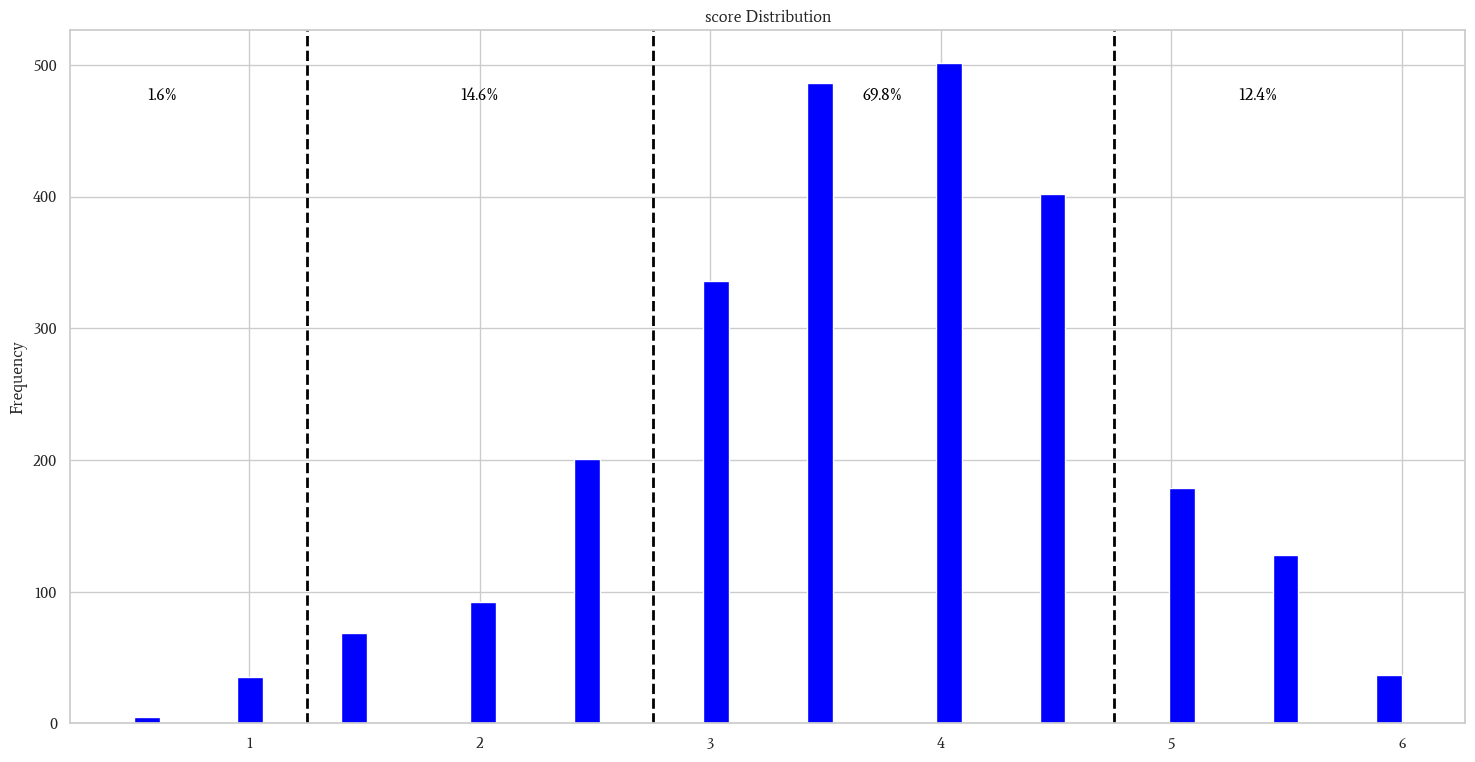

In [7]:
# histogram of scores
plot_hist_with_annot(scores, 'score', bins=None, vertical_lines=[1.25, 2.75, 4.75])

- Scores are relatively normally distributed, with a slight left skew.

# Data Cleaning

## Time

In [4]:
# assert that action_time col is equal to (up_time - down_time)
assert logs.action_time.equals(logs.up_time - logs.down_time)

- action_time represents how long a single action took.

In [5]:
# get unique ids
ids = logs.id.unique()

# look at first and loast rows for the first and second id
show_first_last_rows(logs, ids[0])
show_first_last_rows(logs, ids[1])

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2556,001519c8,2557,1801877,1801969,92,Nonproduction,Leftclick,Leftclick,NoChange,1046,255,3.5


,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
2557,0022f953,1,30623,30853,230,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
5010,0022f953,2454,1788842,1788969,127,Nonproduction,ArrowDown,ArrowDown,NoChange,1519,320,3.5


- User 001519c8 waited til 4056 milliseconds (4 seconds) to make their first action. 
- User 0022f953 waited over 30 seconds.

## Activity

In [8]:
for activity in logs['activity'].unique():
    # get rows where activity == activity
    activity_df = logs.query('activity == @activity')

    # get num of unique events
    unique_events = list(set(activity_df['down_event'].unique()) | set(activity_df['up_event'].unique()))
    unique_text_change = activity_df['text_change'].unique()
    print(f'\n{activity} has {len(unique_events)} unique events')
    print(f'{activity} has {len(unique_text_change)} unique text changes')

    # print if under 20
    if len(unique_events) <= 20:
        print(unique_events)
    if len(unique_text_change) <= 20:
        print(unique_text_change)


Nonproduction has 94 unique events
Nonproduction has 1 unique text changes
['NoChange']

Input has 48 unique events
Input has 47 unique text changes

Remove/Cut has 5 unique events
Remove/Cut has 2179 unique text changes
['Rightclick', 'z', 'Delete', 'Backspace', 'x']

Replace has 46 unique events
Replace has 1826 unique text changes

Move has 2 unique events
Move has 35 unique text changes
['Leftclick', 'z']

Paste has 22 unique events
Paste has 328 unique text changes


### Nonproduction

In [7]:
# look at Nonproduction
display(logs.query('activity == "Nonproduction"')['text_change'].value_counts())
display(logs.query('text_change == "NoChange"')['activity'].value_counts())

text_change
NoChange    703851
Name: count, dtype: int64

activity
Nonproduction    703851
Name: count, dtype: int64

- "Nonproduction" activity values and "NoChange" text_change values are synonomous.
- Even though "Nonproduction" activity values have 94 unique events, these really don't matter, because the user isn't modifying anything.

### Input

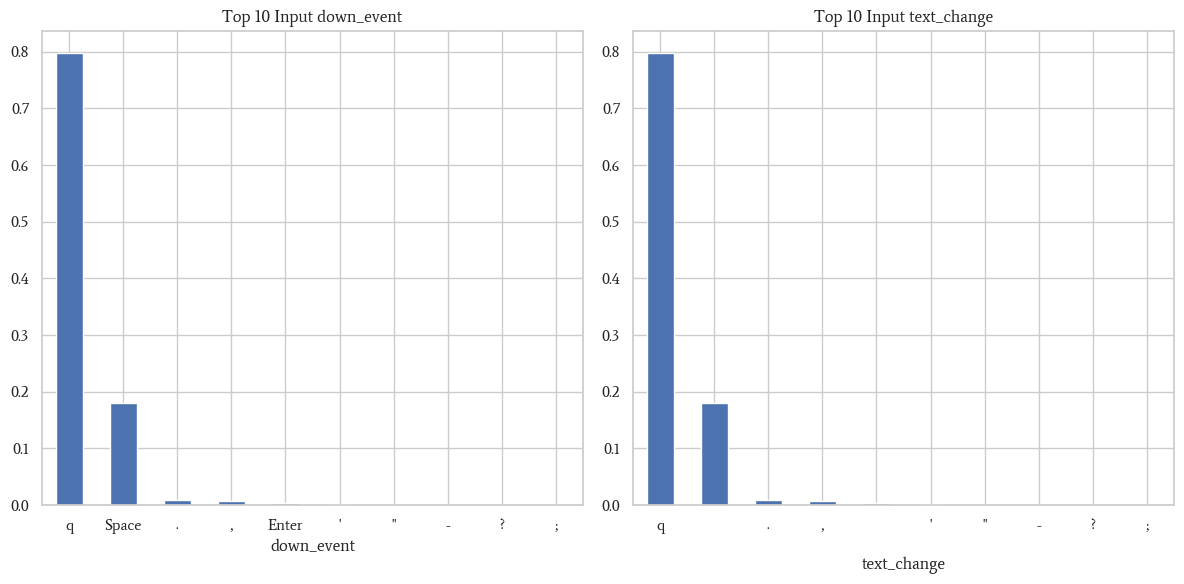

In [ ]:
# get top 10 Input down_event and text_change values
top_10_down_event = logs.query('activity == "Input"')['down_event'].value_counts(normalize=True).head(10)
top_10_text_change = logs.query('activity == "Input"')['text_change'].value_counts(normalize=True).head(10)

# plot both next to each other
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
top_10_down_event.plot(kind='bar', ax=ax[0], title='Top 10 Input down_event')
top_10_text_change.plot(kind='bar', ax=ax[1], title='Top 10 Input text_change')

# make x label rotation 0
for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

- "q" values make up 80% of the "Input" values in the dataset. This essentially represents a single character (a-z) input.
- Spaces (' ') make up about 18%.
- Punctuation, other special chars ("Enter" or "\n"), and revision (Backspace/Delete) make up the other 2%.

### Remove/Cut

In [36]:
# get removes
removes = logs.query('activity == "Remove/Cut"')

# look at value counts
display(removes.down_event.value_counts(normalize=True))
display(removes.up_event.value_counts(normalize=True))

down_event
Backspace     0.988736
Delete        0.010963
x             0.000128
z             0.000095
Rightclick    0.000078
Name: proportion, dtype: float64

up_event
Backspace     0.988736
Delete        0.010963
x             0.000128
z             0.000095
Rightclick    0.000078
Name: proportion, dtype: float64

- Vast majority (99%) of event values for Remove/Cut are Backspace/Delete actions.

### Replace
This is technically a combination of "Remove/Cut" and "Input" activities at the same time.

In [ ]:
# get replace
replace = logs.query('activity == "Replace"')

# get unique values
unique = replace.text_change.unique()

# print count and first 10
print({len(unique)})
print(unique[:10])

{1826}
[' qqq qqqqq  =>  ' 'qqqqq qq => q' 'qqqq  => q' 'qqqqqqq qqqqqq  => q'
 'qq qqqqqqqq qqqqq => q' 'qqqqq  => q' 'qqqqqqqqq  => q' 'qqqqqq => q'
 'qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq  => q' 'qqqqqqq  => q']


- The arrow (=>) indicates that the text on the left is being replaced by the text on the right. "qqqq qqqq => q" indicates that 2 four-letter words are being replaced by a single character.

In [ ]:
# get a row where text_change is equal to 2 words replaced by a space
logs.query("text_change == ' qqq qqqqq  =>  '")

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
462,001519c8,463,455954,456082,128,Replace,Space,Space,qqq qqqqq =>,161,39


In [ ]:
# look at row 462 and its prior row
logs.loc[[461, 462]]

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
461,001519c8,462,453154,455413,2259,Nonproduction,Leftclick,Leftclick,NoChange,171,41
462,001519c8,463,455954,456082,128,Replace,Space,Space,qqq qqqqq =>,161,39


- When text_change shows 2 words to the left of the "=>", we can see the word count drop by 2, as we are replacing these 2 words with only a space.

In [ ]:
# get a row where text_change is equal to 8 words replaced by a character
logs.query("text_change == 'qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq  => q'")

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
5115,0042269b,105,104507,104617,110,Replace,q,m,qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq => q,1,4


In [ ]:
# look at row 5115 and its prior row
logs.loc[[5114, 5115]]

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
5114,0042269b,104,104404,104404,0,Nonproduction,Shift,Shift,NoChange,47,12
5115,0042269b,105,104507,104617,110,Replace,q,m,qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq => q,1,4


- When now see 8 words (46 characters) to the left of the "=>", the word_count drops by 8, even though a character is replacing these.
- The cursor_position value is dropping by 46, which coincides with the number of characters that we are replacing.

### Move

In [ ]:
# get replace
move = logs.query('activity == "Move"')

# look at 3 rows of move
move.head(3)

{35}
['qqqqqqq ' 'qq' 'q'
 ' qqqqq qqqq qqqqqqq qqqq qqqq qqqqqq qqqqqqqq qq qqq qqqqq qq qqqqqqqqqqq qqqqqq qqq qqqqqqqqqqqq qqqqqqqqq qq qqq qqqqqqq. \n\nqqqqqqq qqqqqqq qq qqqq qqqqqq qqq qqqqqqqqqqq qqqq qqq qqqq qq qq qqqqqq qq qqqqqq qq qqqq qqqqqqq qqqqqqq q qqqqqqqqq qq qqqqqqqq qqqqqqqqq qqqq qqqqq qqqqqqq qqqqqq qq qqqqqqq qqqqqqq qq qqqq qqqqqqqqq. qqqq qqqqq qq qqqqqqqqqq qq qqq qqqq qqqqq qqqqq qq qqq qqqqqqqqqq qqqq qqqq '
 'qqqq qqqqqq q qqqq qq qqqqq qqqq qqqq qqqqqqq. qq qqqqqqq qqqqqqqqq qqqq qqq qqqqq qqqqqqqqqqq qq qqq qqqqqqq qqqq qq qqqqqqqq qq qqq qqqqqqq q qqq qq qqqqqqqq. qqqq qqq qqqqqqqq'
 'q qqqqq qqqq qqqq qqqqqqqqq qq qqqqq qqqqq qqqq qq qqqqq qqqqq qqq qqq qqqqqqq. '
 'qqq qqqqqq qqqq qqqqqq qq qq qqqqq qq qqq qqqqq qq qqqqq qqqqqqqq qqqqq qq qq qqq qqqqqqqqq qq qqqqqq?'
 'qqqqqqq'
 ' qq qqqq qq qqqq. qqqq qqqq qqqqqqqq qqq qqqqqqqq. qqqqqqqq qq qqqq qqqqqqqqq qq qqqqqqqq'
 'qqq qqqqqqq qq qqqqqqqqqq qqq qqqqq qqqq q qqqqqq qqqqqq qq qqqqqq qqqqqqqqq qq q

- Lets get this user ID and a few concurrent actions to see how the Move action effects cursor_position and word_count.

In [21]:
# look at rows with indices 2358-2364
logs.loc[2358:2364]

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
2358,001519c8,2359,1379890,1380270,380,Nonproduction,Leftclick,Leftclick,NoChange,292,244
2359,001519c8,2360,1380334,1380334,0,Move,Leftclick,Leftclick,qqqqqqq,290,244
2360,001519c8,2361,1381747,1381763,16,Nonproduction,Leftclick,Leftclick,NoChange,368,244
2361,001519c8,2362,1382693,1382843,150,Nonproduction,Leftclick,Leftclick,NoChange,289,244
2362,001519c8,2363,1382896,1382896,0,Move,Leftclick,Leftclick,qq,287,244
2363,001519c8,2364,1384340,1385567,1227,Nonproduction,Leftclick,Leftclick,NoChange,297,244
2364,001519c8,2365,1386525,1386655,130,Replace,q,q,qqqqqqq qqqqqq => q,283,242


- In row 2359, the user is moving a 7-character word back 2 cursor positions. word_count does not change, as nothing is being added with this action.

### Paste

In [31]:
# get paste activity
paste = logs.query('activity == "Paste"')

# view a row
paste.sample()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
5406117,a8219621,663,421627,421708,81,Paste,v,v,"qq qq qqqqqqqqqq qq qqq qqq qqqqqqqqq, qqqqqqq qq qq qqq qqq qq qqqq qq qqq qqqqqqqqqqq. \n",90,73


In [32]:
# look at rows with indices 5406116-5406118
logs.loc[5406116:5406118]

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
5406116,a8219621,662,421498,421498,0,Nonproduction,Control,Control,NoChange,0,56
5406117,a8219621,663,421627,421708,81,Paste,v,v,"qq qq qqqqqqqqqq qq qqq qqq qqqqqqqqq, qqqqqqq qq qq qqq qqq qq qqqq qq qqq qqqqqqqqqqq. \n",90,73
5406118,a8219621,664,425064,425190,126,Nonproduction,Leftclick,Leftclick,NoChange,420,73


- In this paste example, the user pasted 17 words and word_count increased by 17.

## Text Change

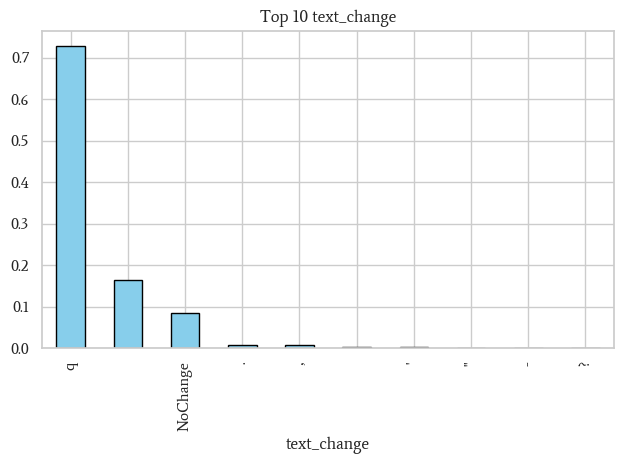

In [42]:
# plot the top 10 most common text_change values
logs['text_change'].value_counts(normalize=True)[:10].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 text_change')
plt.tight_layout()
plt.show()

- "q" values make up the majority of text_change values in the dataset.

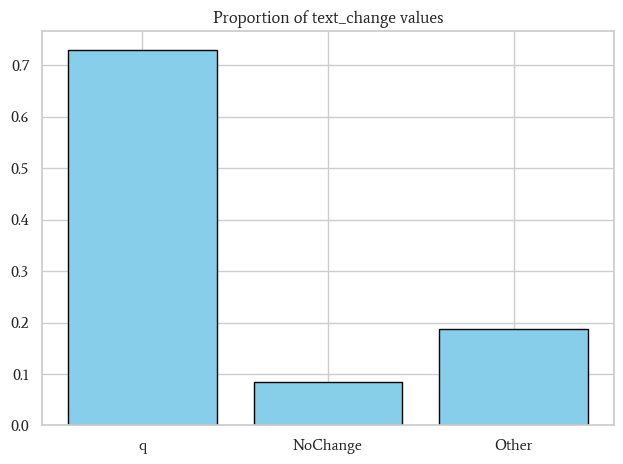

In [43]:
# get rows where text_change is q, NoChange, or neither
q = logs.query('text_change == "q"')
no_change = logs.query('text_change == "NoChange"')
other_text_change = logs.query('text_change != "q" and text_change != "NoChange"')

# look at proportions
q_proportion = len(q) / len(logs)
no_change_proportion = len(no_change) / len(logs)
other_text_change_proportion = len(other_text_change) / len(logs)

# plot
plt.bar(['q', 'NoChange', 'Other'], [q_proportion, no_change_proportion, other_text_change_proportion], color='skyblue', edgecolor='black')
plt.title('Proportion of text_change values')
plt.tight_layout()
plt.show()

- About 73% of all text changes are "q" (a single char input).
- 8% are "NoChange", which we've already establised to be "Nonproduction" activities. The only thing that may change in these actions is the cursor_position.
- 19% are "Other", which we will inspect now.

## Down/Up Events

### Mismatching Events

In [46]:
# where down and up event differ
diff_events = logs.query('down_event != up_event')['activity'].value_counts()

# calculate proportion
diff_events_pct = diff_events.sum() / logs.shape[0]

# print proportion and actual values
print(f'{diff_events_pct:.2%} of rows have different down and up events')
diff_events

0.01% of rows have different down and up events


activity
Replace          523
Input              7
Nonproduction      4
Name: count, dtype: int64

- Mismatching down/up events only make up a fraction of our data (0.01%).
- It is pretty much always a "Replace" activity.

In [47]:
# get ids that contain at least one instance of different down and up events
ids_diff_events = logs.query('down_event != up_event')['id'].unique()

# print number of ids
print(f'{len(ids_diff_events)} ids (out of {logs.id.nunique()}) have at least one instance of different down and up events.')

# index into scores and get mean score for ids_diff_events
scores.query('id in @ids_diff_events')['score'].mean()

336 ids (out of 2471) have at least one instance of different down and up events.


4.144345238095238

- Only about 13% of our writers had at least one instance of different down and up events.
- Their mean sore was 4.14, which is actually 0.44 points above the overall mean.

### Unique Events

In [48]:
# unique down + up events
unique_events = list(set(logs['down_event'].unique()) | set(logs['up_event'].unique()))
print(len(unique_events))
print(sorted(unique_events))

132
['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '5', ':', ';', '<', '=', '>', '?', '@', 'A', 'Alt', 'AltGraph', 'ArrowDown', 'ArrowLeft', 'ArrowRight', 'ArrowUp', 'AudioVolumeDown', 'AudioVolumeMute', 'AudioVolumeUp', 'Backspace', 'C', 'Cancel', 'CapsLock', 'Clear', 'ContextMenu', 'Control', 'Dead', 'Delete', 'End', 'Enter', 'Escape', 'F', 'F1', 'F10', 'F11', 'F12', 'F15', 'F2', 'F3', 'F6', 'Home', 'I', 'Insert', 'Leftclick', 'M', 'MediaPlayPause', 'MediaTrackNext', 'MediaTrackPrevious', 'Meta', 'Middleclick', 'ModeChange', 'NumLock', 'OS', 'PageDown', 'PageUp', 'Pause', 'Process', 'Rightclick', 'S', 'ScrollLock', 'Shift', 'Space', 'T', 'Tab', 'Unidentified', 'Unknownclick', 'V', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x80', '\x96', '\x97', '\x9b', '¡', '¿', 'Â´', 'Ä±', 'Å\x9f', 'Ë\x86', 'â\x80\x93'

- 132 unique events.
- Many of the strange events are improper encodings ("â\x80\x93" = "-"). I will remap these, and do the same for the text_change column.

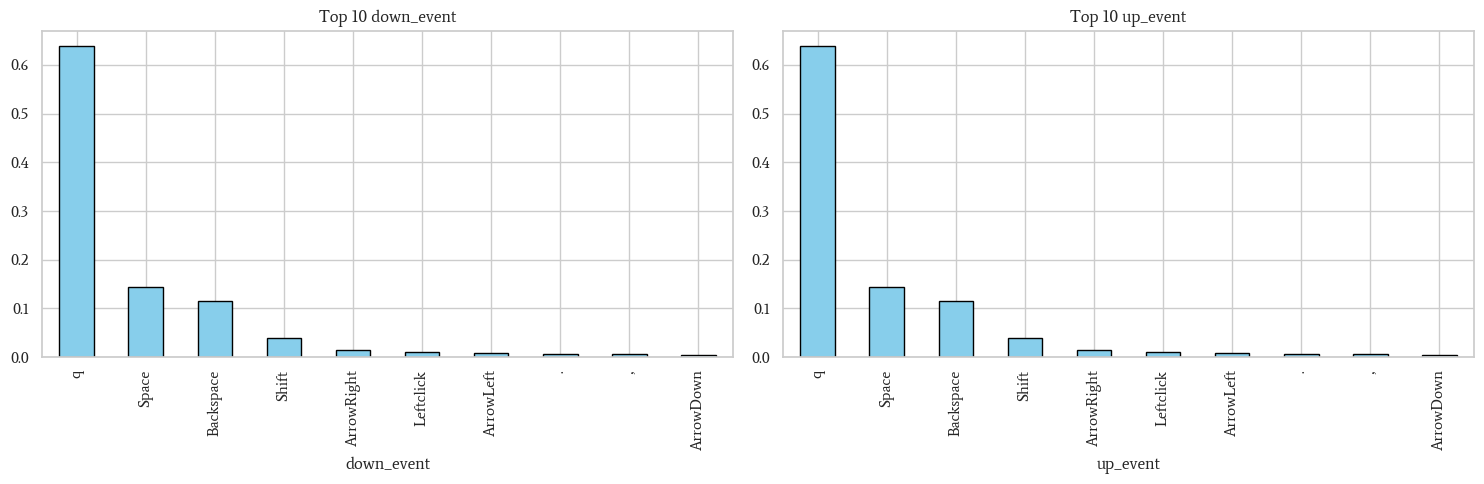

In [4]:
# create encodings
encodings = {
    '\x80': '€',  # Euro sign (Windows-1252)
    '\x96': '–',  # En dash (Windows-1252)
    '\x97': '—',  # Em dash (Windows-1252)
    '\x9b': '‚',  # Single low quotation mark (Windows-1252)
    'Â´': '´',  # Acute accent (UTF-8)
    'Ä±': 'ı',  # Dotless 'i' (Turkish, UTF-8)
    'Å\x9f': 'ş',  # S-cedilla (Turkish, UTF-8)
    'Ë\x86': 'ˆ',  # Circumflex modifier (UTF-8)
    'â\x80\x93': '–'  # En dash (UTF-8)
}

# map to both down and up events
logs['down_event'] = logs['down_event'].replace(encodings)
logs['up_event'] = logs['up_event'].replace(encodings)
logs['text_change'] = logs['text_change'].replace(encodings)

# plot the top 30 most common down_event and up_event
top_down_events = logs['down_event'].value_counts(normalize=True)[:10]
top_up_events = logs['up_event'].value_counts(normalize=True)[:10]

# plot both as barcharts
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
top_down_events.plot(kind='bar', ax=ax[0], color='skyblue', edgecolor='black')
top_up_events.plot(kind='bar', ax=ax[1], color='skyblue', edgecolor='black')
ax[0].set_title('Top 10 down_event')
ax[1].set_title('Top 10 up_event')
plt.tight_layout()
plt.show()

- The 'q' action makes up over 60% of our events. This character is simply a fill-in value for and character (a-z) input.

In [53]:
# inspect the 8 capital chars
acfimstv = ['A', 'C', 'F', 'I', 'M', 'S', 'T', 'V']
logs.query('down_event in @acfimstv or up_event in @acfimstv').activity.value_counts()

activity
Nonproduction    9
Paste            4
Replace          2
Name: count, dtype: int64

- The capital char events are rare, and only found in "Nonproduction", "Replace", and "Paste" activities.

## Cursor Position

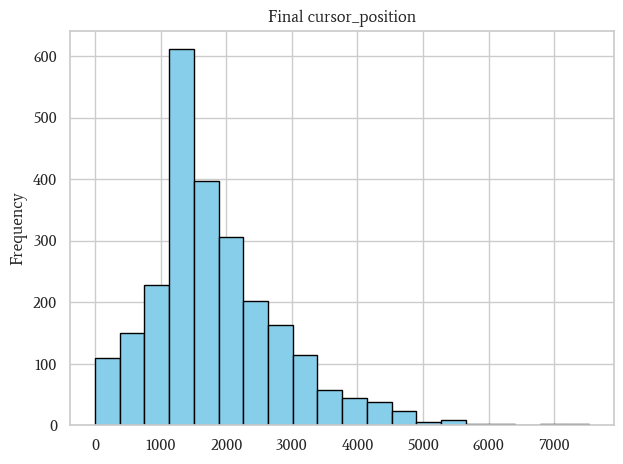

,count,mean,std,min,25%,50%,75%,max
cursor_position,2471.0,1839.578308,1014.585047,0.0,1210.5,1624.0,2345.0,7534.0


In [17]:
# get final cursor_position value for each id
final_cursor_position = logs.groupby('id')['cursor_position'].last()

# plot
final_cursor_position.plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Final cursor_position')
plt.tight_layout()
plt.show()

# describe
final_cursor_position.describe().to_frame().T

In [18]:
# map scores to final_cursor_position and view correlation
final_cursor_position_score = final_cursor_position.to_frame().merge(scores, left_index=True, right_on='id')
final_cursor_position_score[['score', 'cursor_position']].corr()

,score,cursor_position
score,1.000000,0.476897
cursor_position,0.476897,1.000000


In [19]:
# get mean cursor_position for each id
mean_cursor_position = logs.groupby('id')['cursor_position'].mean()

# view correlation
mean_cursor_position_score = mean_cursor_position.to_frame().merge(scores, left_index=True, right_on='id')
mean_cursor_position_score[['score', 'cursor_position']].corr()

,score,cursor_position
score,1.000000,0.622665
cursor_position,0.622665,1.000000


- Cursor position has a moderate positive correlation with the essay score.

## Word Count

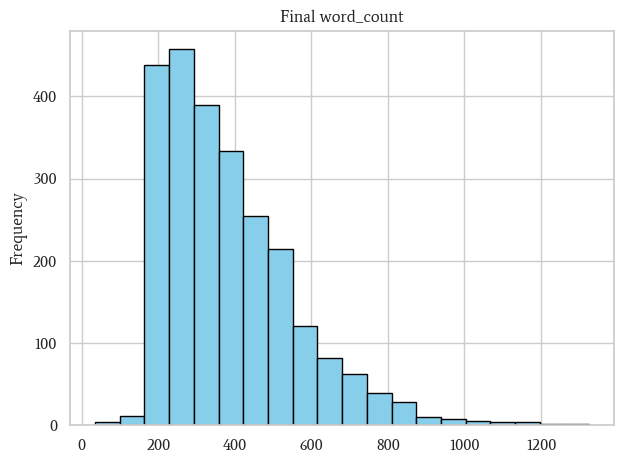

,count,mean,std,min,25%,50%,75%,max
word_count,2471.0,386.1121,171.773394,35.0,250.0,346.0,477.0,1326.0


In [11]:
# get final word_count value for each id
final_word_count = logs.groupby('id')['word_count'].last()

# plot
final_word_count.plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Final word_count')
plt.tight_layout()
plt.show()

# describe
final_word_count.describe().to_frame().T

- Most word counts fell in the range of 200-500 words.

In [15]:
# map scores to final_word_count and view correlation
final_word_count_score = final_word_count.to_frame().merge(scores, left_index=True, right_on='id')
final_word_count_score[['score', 'word_count']].corr()

,score,word_count
score,1.000000,0.640241
word_count,0.640241,1.000000


- Final word count has a moderate positive correlation with the essay's score.

# Feature Engineering

In [4]:
# create features
features = create_features(logs)

# check
print(features.shape)
features.sample()

(2471, 16)


,id,start_delay,tot_time,num_actions,mean_action_time,std_action_time,prop_nonproduction,prop_input,prop_remove_cut,prop_replace,prop_move,prop_paste,cursor_retraction,word_retraction,final_word_count,final_word_count_squared
708,4b40b5c0,2313,126483,1502,84.20972,35.404345,0.061917,0.877497,0.060586,0.0,0.0,0.0,103,19,219,47961


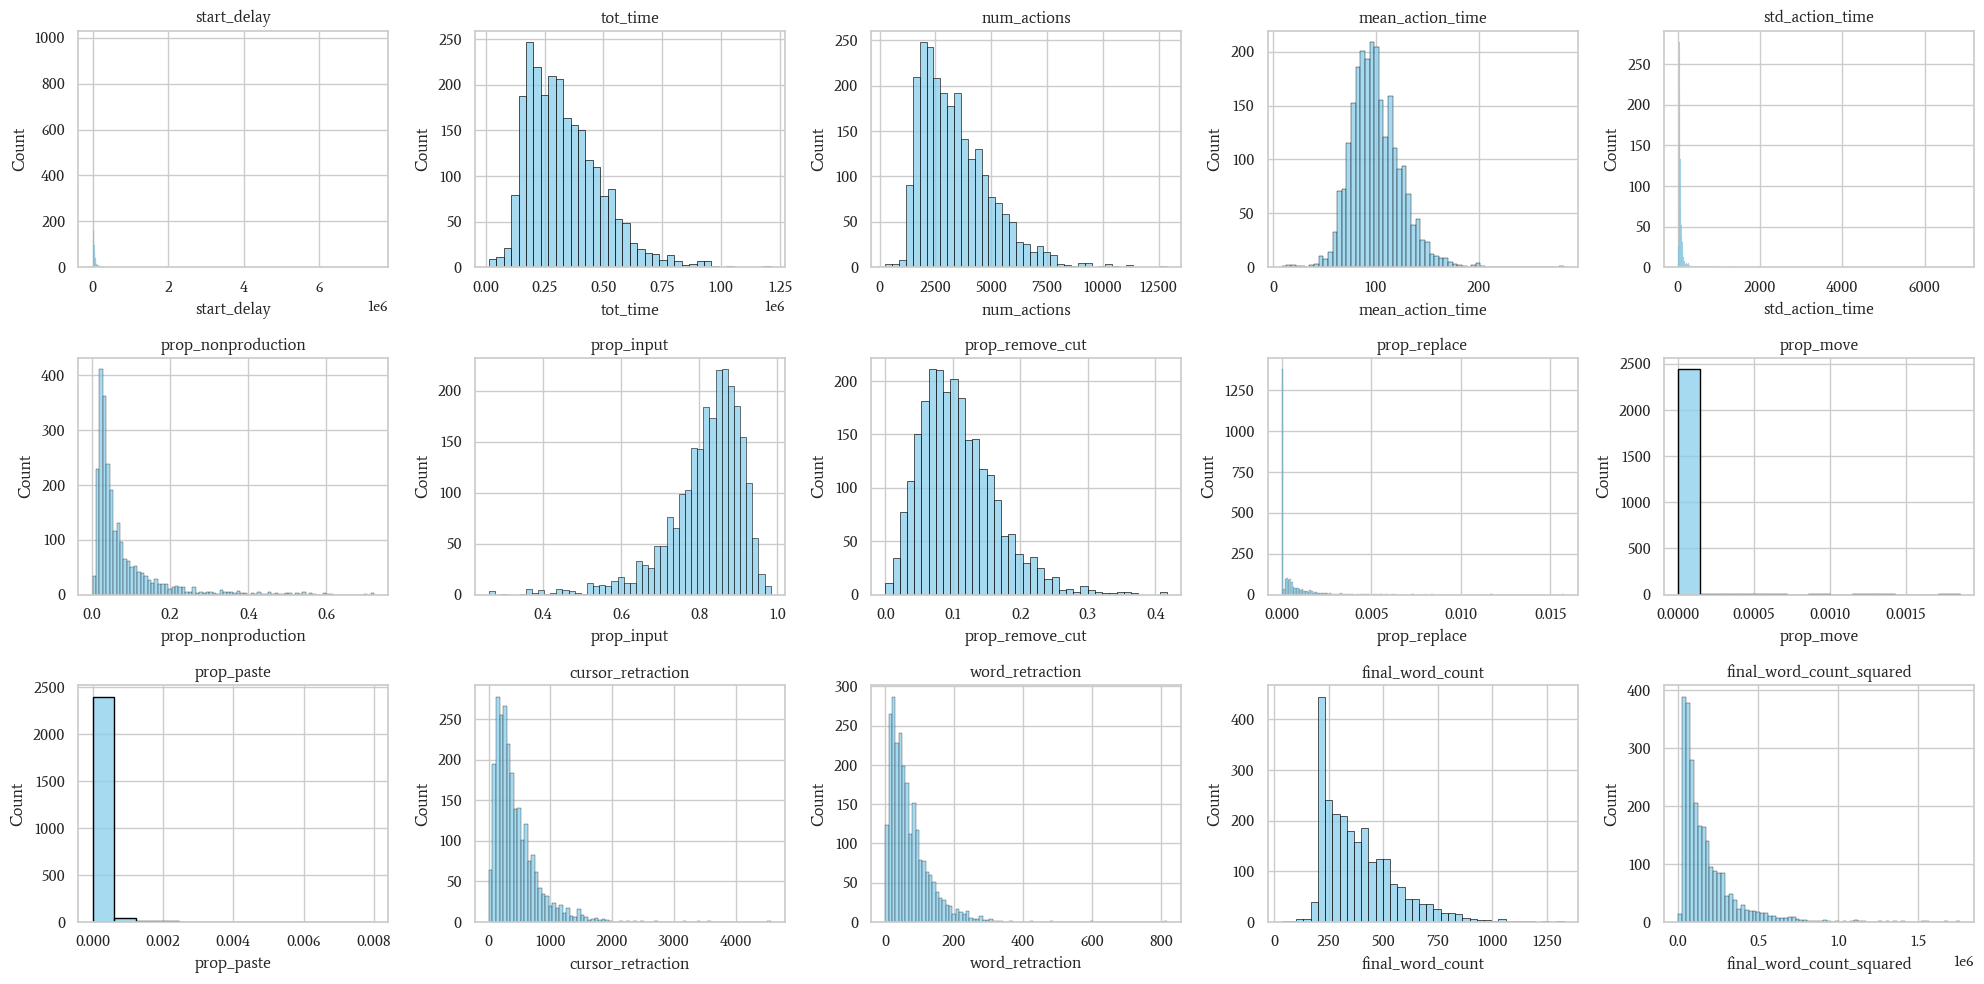

In [5]:
# plot histograms for all 15 features (check for normality)
n_rows = 3
n_cols = 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 10))
for i, col in enumerate(features.columns[1:]):
    sns.histplot(features[col], ax=ax[i // n_cols, i % n_cols], color='skyblue', edgecolor='black')
    ax[i // n_cols, i % n_cols].set_title(col)
plt.tight_layout()
plt.show()

- The only feature that looks normally distributed is mean_action_time.
- We will use MinMaxScaler instead of StandaradScaler to address these non-normal distributions.

# Baseline (Linear Regression)

RMSE: 0.7248


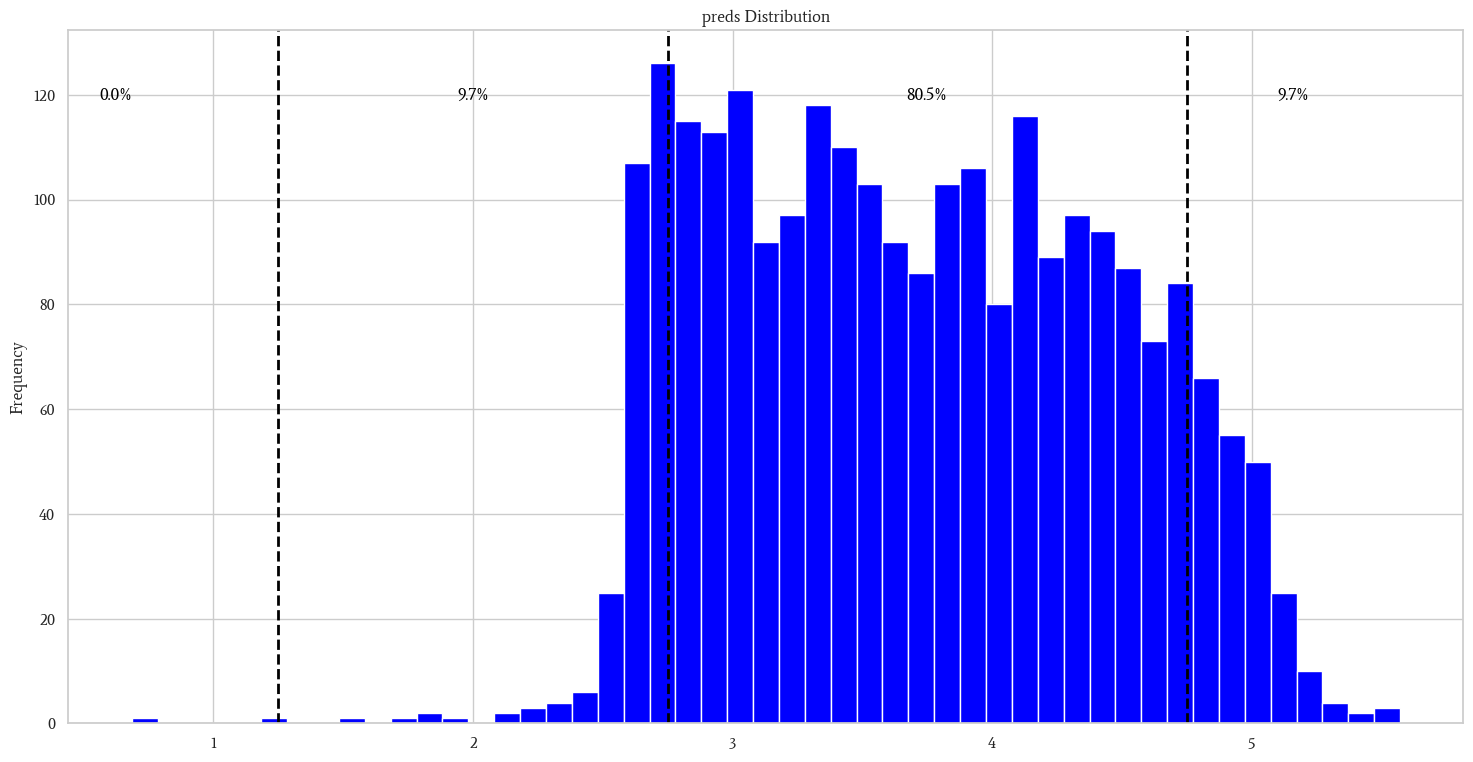

,count,mean,std,min,25%,50%,75%,max
preds,2471.0,3.709317,0.736617,0.685547,3.066317,3.671875,4.310791,5.572266


In [ ]:
# map scores to features
features_scores = features.merge(scores, on='id')

# define a pipeline
model = LinearRegression()
scaler = MinMaxScaler()
pipeline = Pipeline([('scaler', scaler), ('model', model)])

# get X and y
X = features_scores.drop(columns=['id', 'score'])
y = features_scores['score']

# get preds
preds = cross_val_predict(pipeline, X, y, cv=10)

# round to nearest 0.5
rounded_preds = np.round(preds * 2) / 2

# clip to 0.5-6
final_preds = np.clip(preds, 0.5, 6)

# print RMSE
rmse = root_mean_squared_error(y, final_preds)
print(f'RMSE: {rmse:.4f}')

# convert to df
preds_df = pd.DataFrame(final_preds, columns=['preds'])

# plot
plot_hist_with_annot(preds_df, 'preds', bins=None, vertical_lines=[1.25, 2.75, 4.75])
preds_df.describe().T

- The model has a tendency to predict values 3-5 much more frequently than they actually occur.
- In the original scores distribution, about 17% of the data had a score of 2.5 or less. The model is predicting in this range very rarely.
- I did also try rounding the predictions to the nearest 0.5, but loss increased. Standardizing the preds (attempting to shift the distribution left) also increased RMSE.

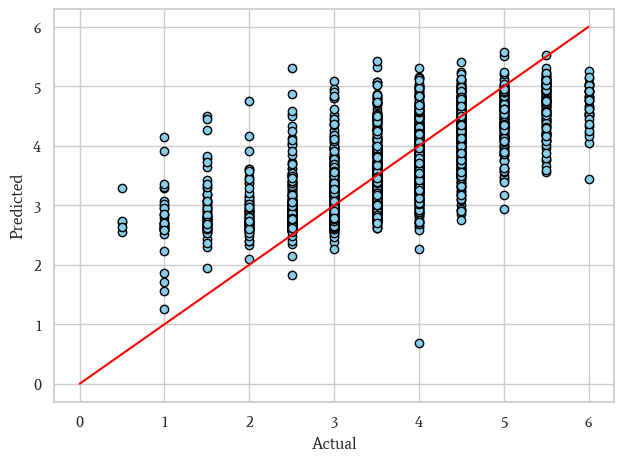

In [ ]:
# scatterplot with predicted on x and actual on y
plt.scatter(y, final_preds, c='skyblue', edgecolor='black')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# add a diagonal line
plt.plot([0, 6], [0, 6], color='red')
plt.tight_layout()
plt.show()

- The linear model usually overpredicts for the lower scores, and overpredicts for the higher scores.
- We will hypertune a non-linear model (XGBoost) to hopefully overcome these pitfalls.

# XGBoost

In [17]:
# define the parameter search space
param_bounds = {
    'max_depth': (3, 10),
    'n_estimators': (100, 1000),
    'learning_rate': (0.001, 0.1),
    'gamma': (0, 0.5),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'colsample_bylevel': (0.5, 1.0),
    'colsample_bynode': (0.5, 1.0)
}

# run bayesian optimization
optimizer = BayesianOptimization(
    f=lambda max_depth, n_estimators, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, colsample_bylevel, colsample_bynode: 
        xgb_cv(max_depth, n_estimators, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, colsample_bylevel, colsample_bynode, X, y),
    pbounds=param_bounds,
    random_state=SEED,
    verbose=2
)

# optimize for 110 iterations
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.6957   | 0.5052    | 0.7509    | 0.7479    | 0.06691   | 0.01507   | 4.53      | 4.767     | 323.3     | 0.542     |
| 2         | -0.7037   | 0.6727    | 0.5834    | 0.9393    | 0.4755    | 0.004836  | 7.894     | 6.155     | 908.2     | 0.8334    |
| 3         | -0.7121   | 0.7739    | 0.8512    | 0.6932    | 0.3472    | 0.08266   | 6.26      | 9.465     | 823.4     | 0.9917    |
| 4         | -0.7168   | 0.5848    | 0.7605    | 0.9728    | 0.3248    | 0.08622   | 9.796     | 2.67      | 318.8     | 0.9367    |
| 5         | -0.7204   | 0.9531    | 0.8791    | 0.6735    | 0.2318    | 0.06144   | 6.474     | 5.302     | 492.0     | 0.9352    |
| 6         | -0.7023   | 0.5937    | 0.8438    | 0.8518    | 

In [ ]:
# best params
best_params = {'colsample_bylevel': 0.5051870769428499, 'colsample_bynode': 0.7509372960743694, 'colsample_bytree': 0.747886646567073, 'gamma': 0.06691476447963829, 
               'learning_rate': 0.015068997459999317, 'max_depth': 4, 'min_child_weight': 4.766573624594072, 'n_estimators': 323, 'subsample': 0.542029825582675}

# Final Accuracy Check

In [37]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

# train model with best parameters
pipeline = Pipeline([('scaler', MinMaxScaler()), ('model', XGBRegressor(**best_params))
])
pipeline.fit(X_train, y_train)

# evaluate on val data
preds = pipeline.predict(X_val)
rmse = root_mean_squared_error(y_val, preds)
print(f'RMSE without rounding: {rmse:.4f}')

# round to nearest 0.5 and evaluate
rounded_preds = np.round(preds * 2) / 2
rmse = root_mean_squared_error(y_val, rounded_preds)
print(f'RMSE with rounding: {rmse:.4f}')

RMSE without rounding: 0.7033
RMSE with rounding: 0.7014


- Final RMSE of about 0.7 on the validation data.
- Rounding did boost performance slightly.

# Format Test Data

In [26]:
# apply these transformations to test data
test = pd.read_csv('data/test_logs.csv')

# combine 'Move' activities
test.loc[test['activity'].str.contains('Move', na=False), 'activity'] = 'Move'

# check for nulls
show_shape_and_nulls(test)

Shape: (6, 11)
Null values:


,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0,0,0,0,0,0,0,0,0,0,0


- Test data is ready for predictions.

# Final Predictions

In [41]:
# create test features
test_features = create_features(test)

# define X
X_test = test_features.drop(columns=['id'])

# fit pipeline on all data
pipeline.fit(X, y)

# get predictions
preds = pipeline.predict(X_test)

# round to nearest 0.5 and clip
rounded_preds = np.round(preds * 2) / 2
final_preds = np.clip(rounded_preds, 0.5, 6)

# create submission df
submission = pd.DataFrame({'id': test['id'].unique(), 'score': final_preds})

# check
submission.sample()

,id,score
2,4444cccc,2.0


In [42]:
# save submission
submission.to_csv('submission.csv', index=False)